Была сделана нейросеть через кросс-модальное внимание.
Однако достичь задачи в <50 MAE не удается.
Максимум, который был достугнут 70 MAE. Были различные эксперементы с единым LR и отдельными по частям в моделях. С регуляризацией и безв разных местах.
С нормализацией в разных местах: в базовой модели на выход, в кросс-модальной модели перед входом в attention, после в регрессоре.
Самым удачным стал вариант с нормализацией в регрессоре + дропаут, все остальные нормализации выключены.
Ниже на скирине сравнение без нормализации (розовым цветом) и с нормализацией (зеленым)
тренировка
![alt text](<Снимок экрана 2025-08-25 011046.png>) 
валидация
![alt text](<Снимок экрана 2025-08-25 011336.png>) 
По итогу по ошибке валидации графики сошлись, однако с нормализацией график выгляди более лучше.

Были экспереметы с разыми вариациями:
![alt text](<Снимок экрана 2025-08-25 014512.png>)

Так и не смог понять, что именно надо сделать, что опустить ошибку ниже. Возможно, добавить двух-направленное внимание, но как будто не хватает прям мощного толчка.

В большм количестве эпох смысла не вижу, т.к трейн хоть и падал в конце чуть, но валидация начала барахтаться на одном месте, иногда даже расти.

Подходы к обогащению/аугментации данных применяются самые стандартные.


In [1]:
import torch
from torch.utils.data import DataLoader
from functools import partial
import matplotlib.pyplot as plt
import sys, os
sys.path.append("scripts")
from transformers import AutoTokenizer

from scripts.dataset import MultimodalDataset, collate_fn, get_transforms
from scripts.utils import CrossAttentionModel, MultimodalModel  
from scripts.config import Config 

d:\Нейросети яндекс практикум\multimodal_calory_dish\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ClearML Task: created new task id=608318367dee4d0ea15aaa3817c1baec
2025-08-25 00:06:38,062 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/e0207a4e59484b31931844591cb879ca/experiments/608318367dee4d0ea15aaa3817c1baec/output/log
start
cuda
Разморожен слой: encoder.layer.11.attention.self.query.weight
Разморожен слой: encoder.layer.11.attention.self.query.bias
Разморожен слой: encoder.layer.11.attention.self.key.weight
Разморожен слой: encoder.layer.11.attention.self.key.bias
Разморожен слой: encoder.layer.11.attention.self.value.weight
Разморожен слой: encoder.layer.11.attention.self.value.bias
Разморожен слой: encoder.layer.11.attention.output.dense.weight
Разморожен слой: encoder.layer.11.attention.output.dense.bias
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.weight
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.bias
Разморожен слой: encoder.layer.11.intermediate.dense.weight
Ра

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = Config()

# Инициализация модели
model = CrossAttentionModel(config).to(device)
model.load_state_dict(torch.load(config.SAVE_PATH, map_location=device))
model.eval()

tokenizer = AutoTokenizer.from_pretrained(config.TEXT_MODEL_NAME)

In [3]:
# Тестовые трансформации
test_transforms = get_transforms(config, ds_type="test")

test_dataset = MultimodalDataset(config, test_transforms, ds_type="test")

test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    collate_fn=partial(collate_fn, tokenizer=tokenizer),
    num_workers=4,
    pin_memory=True
)

In [5]:
import torchmetrics

mae_metric = torchmetrics.MeanAbsoluteError().to(device)

all_preds = []
all_labels = []
all_indices = [] 

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        preds = model(
            input_ids=batch["input_ids"].to(device),
            attention_mask=batch["attention_mask"].to(device),
            image=batch["image"].to(device)
        )
        labels = batch["label"].to(device)

        mae_metric.update(preds, labels)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_mae = mae_metric.compute().item()
print(f"Финальное MAE на тесте: {final_mae:.2f}")

Финальное MAE на тесте: 69.99


In [ ]:
import os
import numpy as np
from dataset import Dataset

errors = np.abs(np.array(all_preds) - np.array(all_labels))
top5_idx = np.argsort(errors)[-5:]

for idx in top5_idx:
    dish_id = test_dataset.df.loc[idx, "dish_id"]  
    print(f"Dish: {dish_id}, True: {all_labels[idx]}, Pred: {all_preds[idx]}, Error: {errors[idx]}")

Top-5 worst examples (dish_id, true, pred, error):
Dish: dish_1563389626, True: 498.6200256347656, Pred: 100.24313354492188, Error: 398.37689208984375
Dish: dish_1565811139, True: 902.2000122070312, Pred: 484.35235595703125, Error: 417.84765625
Dish: dish_1565030391, True: 609.3339233398438, Pred: 179.06216430664062, Error: 430.2717590332031
Dish: dish_1558373159, True: 1013.3370361328125, Pred: 570.4044189453125, Error: 442.9326171875
Dish: dish_1558375886, True: 1050.5111083984375, Pred: 577.1705932617188, Error: 473.34051513671875


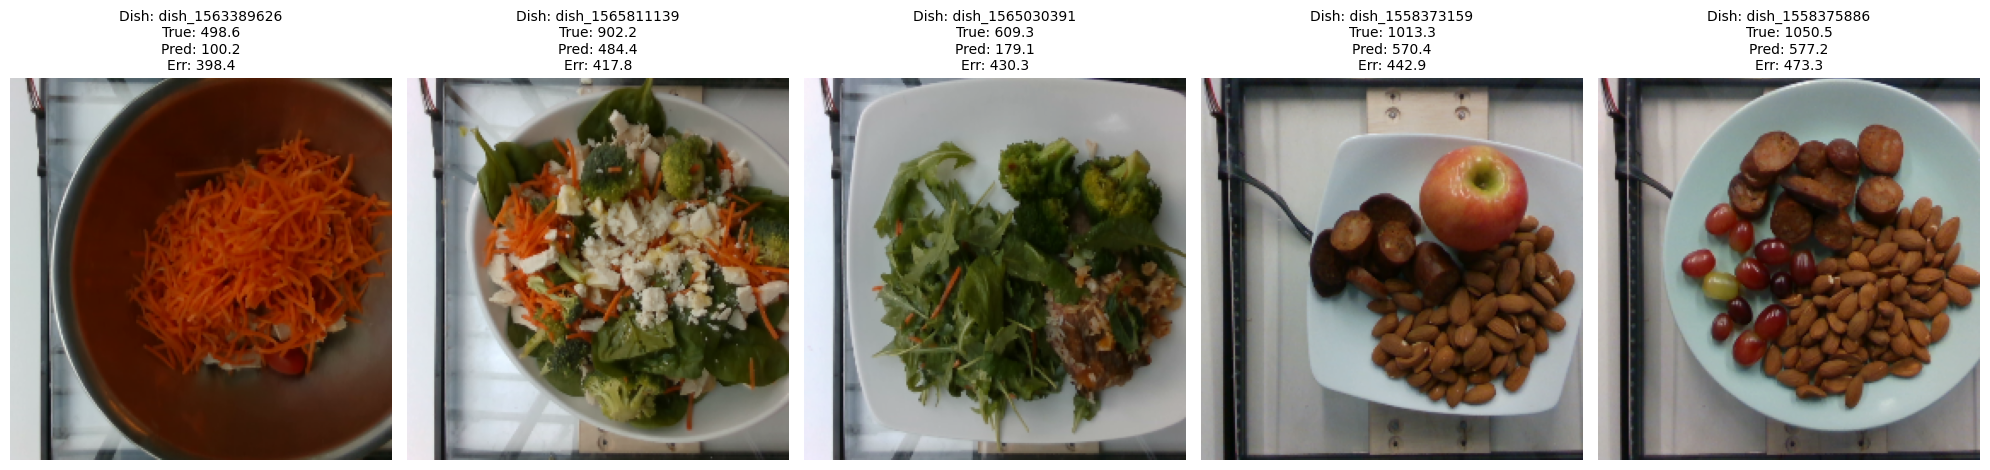

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, idx in enumerate(top5_idx):
    item = test_dataset[idx]
    img = item["image"]
    
    # Денормализация изображения
    img_np = img.permute(1, 2, 0).numpy()  # CHW -> HWC
    img_np = (img_np * std) + mean
    img_np = np.clip(img_np, 0, 1)
    
    label = item["label"]
    dish_id = test_dataset.df.loc[idx, "dish_id"]
    
    axes[i].imshow(img_np)
    axes[i].axis("off")
    axes[i].set_title(
        f"Dish: {dish_id}\nTrue: {all_labels[idx]:.1f}\nPred: {all_preds[idx]:.1f}\nErr: {errors[idx]:.1f}",
        fontsize=10
    )

plt.tight_layout()
plt.show()


Возможные причины низкого качества в сложности блюд. Слишом много мелких объектов, которые можно уловить и выделить.